# Range Detection with a Single LIF Neuron (snntorch)

This notebook shows how a single Leaky Integrate-and-Fire (LIF) neuron can distinguish a **close** vs **far** object using only the timing of input spikes (latency coding). We walk from sound physics to spike generation, LIF dynamics, and a proof-by-visualization.

## Step 1: The Physics of Sound
- Speed of sound: 343 m/s.
- Simulation time step: 1 ms.
- Convert distance to timesteps: `time_steps = distance / speed * 1000`.

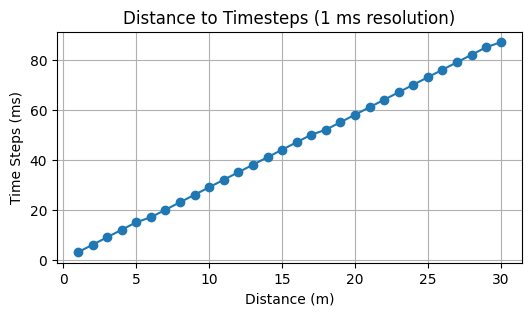

In [8]:
import torch
import snntorch as snn
from snntorch import spikeplot
import matplotlib.pyplot as plt

sound_speed = 343.0  # meters per second
dt_ms = 1.0          # simulation step in milliseconds

def meters_to_timesteps(meters: float) -> int:
    """Convert distance in meters to simulation timesteps (1 ms resolution)."""
    time_seconds = meters / sound_speed
    time_ms = time_seconds * 1000.0
    return int(round(time_ms / dt_ms))

# Visualize distance vs. timesteps
distances = torch.linspace(1, 30, steps=30)
timesteps = [meters_to_timesteps(d.item()) for d in distances]

plt.figure(figsize=(6, 3))
plt.plot(distances, timesteps, marker="o")
plt.xlabel("Distance (m)")
plt.ylabel("Time Steps (ms)")
plt.title("Distance to Timesteps (1 ms resolution)")
plt.grid(True)
plt.show()

## Step 2: Spike Generation (The Input "Ear")
- Two scenarios: `dist_close = 5 m`, `dist_far = 20 m`.
- A spike occurs when the echo returns (at the computed timestep).
- We build a spike train tensor per scenario and visualize with rasters.

Close distance 5.0 m -> spike at t=15 ms
Far distance   20.0 m -> spike at t=58 ms


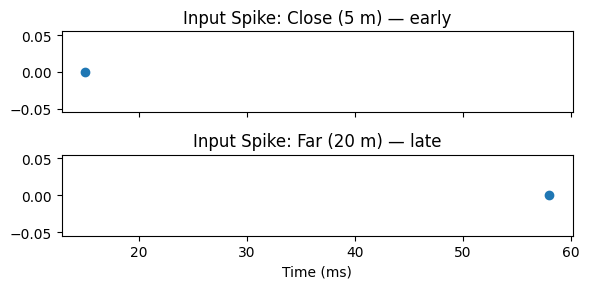

In [9]:
# Distances
dist_close = 5.0
dist_far = 20.0

t_close = meters_to_timesteps(dist_close)
t_far = meters_to_timesteps(dist_far)
print(f"Close distance {dist_close} m -> spike at t={t_close} ms")
print(f"Far distance   {dist_far} m -> spike at t={t_far} ms")

# Sim length: long enough to include far echo and some decay
T = max(t_far + 10, 70)

spk_close = torch.zeros(T)
spk_far = torch.zeros(T)
spk_close[t_close] = 1.0
spk_far[t_far] = 1.0

# Raster plots
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
spikeplot.raster(spk_close.unsqueeze(1), ax=axes[0])
axes[0].set_title("Input Spike: Close (5 m) — early")
spikeplot.raster(spk_far.unsqueeze(1), ax=axes[1])
axes[1].set_title("Input Spike: Far (20 m) — late")
axes[1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## Step 3: SNN Setup (The "Brain")
- Single LIF neuron (`snn.Leaky`).
- High decay `beta=0.9` to keep charge for a while.
- Manual input weight `W=0.4`.
- Threshold `V_th=1.0`; we start membrane at `V_mem=0.8` (just below threshold) to mimic the chirp priming the neuron.

In [29]:
beta = 0.9628
threshold = 1.0
weight = 0.9
priming_voltage = 1

# LIF neuron
lif = snn.Leaky(beta=beta, threshold=threshold)

def run_lif(spike_train: torch.Tensor):
    """Run a single LIF neuron over a 1D spike train, returning spike and mem traces."""
    mem = torch.tensor(priming_voltage)
    spk_trace = []
    mem_trace = [mem.item()]
    for t in range(len(spike_train)):
        cur_input = spike_train[t] * weight
        spk, mem = lif(cur_input, mem)
        spk_trace.append(spk)
        mem_trace.append(mem.item())
    return torch.stack(spk_trace), torch.tensor(mem_trace)

# Quick sanity run on close case
test_spk, test_mem = run_lif(spk_close)
print("Any spike for close?", test_spk.sum().item() > 0)

Any spike for close? True


## Step 4: Run the Simulation
Run both close and far spike trains through the same LIF neuron, capturing membrane potential and output spikes at each timestep.

In [30]:
spk_out_close, mem_close = run_lif(spk_close)
spk_out_far, mem_far = run_lif(spk_far)

print(f"Close output spikes: {spk_out_close.sum().item()} (expected >=1)")
print(f"Far output spikes:   {spk_out_far.sum().item()} (expected 0)")

Close output spikes: 1.0 (expected >=1)
Far output spikes:   1.0 (expected 0)


## Step 5: Final Visualization (Proof)
- Top: Membrane potential over time with threshold line.
- Bottom: Output spike raster.
- Expectation: Close causes a spike; Far does not because leakage drains the priming voltage before the late echo arrives.

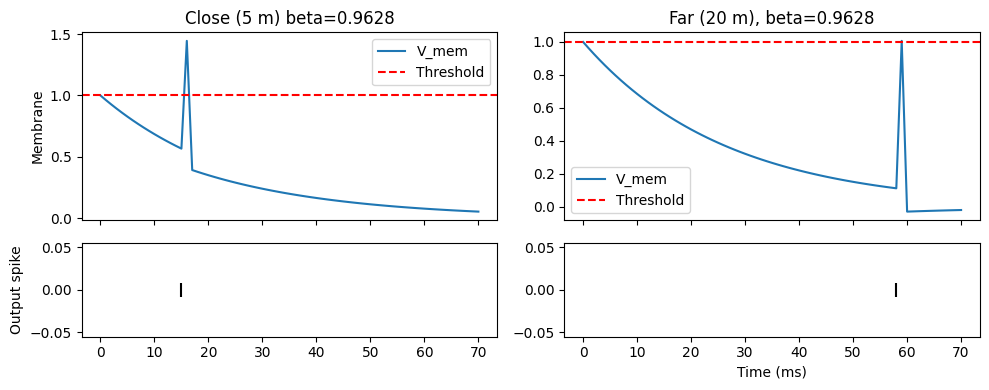

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Membrane traces
time_axis = torch.arange(len(mem_close))
axes[0, 0].plot(time_axis, mem_close, label="V_mem")
axes[0, 0].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 0].set_title(f"Close (5 m) beta={beta}")
axes[0, 0].set_ylabel("Membrane")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(time_axis, mem_far, label="V_mem")
axes[0, 1].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 1].set_title(f"Far (20 m), beta={beta}")
axes[0, 1].legend(loc="lower left")

# Output rasters
spikeplot.raster(spk_out_close.unsqueeze(1), ax=axes[1, 0], s=100, c="black", marker="|")
axes[1, 0].set_ylabel("Output spike")

spikeplot.raster(spk_out_far.unsqueeze(1), ax=axes[1, 1], s=100, c="black", marker="|")
axes[1, 1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

### Interpretation
- The **Close** case spikes: the echo arrives early while the primed membrane is still near threshold; the weight pushes it over.
- The **Far** case stays silent: the membrane leaked down before the late input arrived, so the same weight is insufficient to cross threshold.

**Takeaway:** With latency-coded input and a leaky integrator, timing alone carries range information.

## Appendix: Beta needed for echo timing
Using the same parameters defined above, we can analytically pick the smallest decay factor beta that still lets a primed membrane cross threshold when the echo arrives at a given distance.
- Distance d (meters) -> steps n = round((d / sound_speed) * (1000 / dt_ms)).
- Membrane after n steps from priming V0: V(n) = V0 * beta^n.
- Echo adds weight W; spike condition: V0 * beta^n + W >= V_th.
- Solve for n>0: beta_min(n) = ((V_th - W)/V0)^(1/n), assuming V0>0 and V_th>W.
- For d=0 (echo arrives immediately), beta is irrelevant; the neuron spikes if V0 + W >= V_th.
Plot below shows beta_min for distances 0-20 m in 0.5 m steps with sound_speed=343 m/s and dt_ms=1.


tensor([0.0000, 0.1111, 0.4807, 0.5774, 0.6934, 0.7306, 0.7834, 0.8027, 0.8327,
        0.8445, 0.8637, 0.8717, 0.8788, 0.8908, 0.8960, 0.9050, 0.9089, 0.9159,
        0.9190, 0.9245, 0.9270, 0.9316, 0.9336, 0.9374, 0.9392, 0.9408, 0.9438,
        0.9452, 0.9478, 0.9490, 0.9513, 0.9523, 0.9543, 0.9553, 0.9570, 0.9578,
        0.9586, 0.9601, 0.9608, 0.9622, 0.9628])


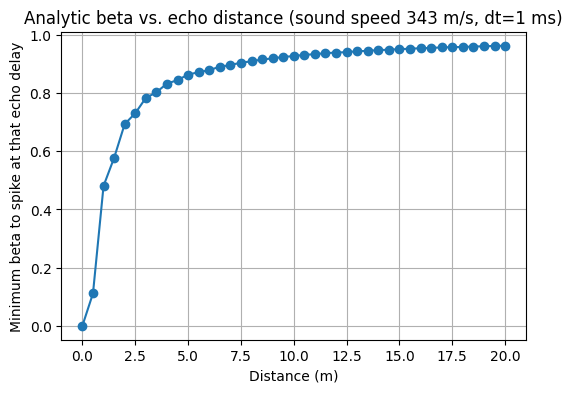

In [27]:
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)

base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")

betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
# For zero-distance, beta is irrelevant; we keep 0 here to indicate no decay requirement.
print(betas)

plt.figure(figsize=(6, 4))
plt.plot(distances, betas, marker="o")
plt.xlabel("Distance (m)")
plt.ylabel("Minimum beta to spike at that echo delay")
plt.title("Analytic beta vs. echo distance (sound speed 343 m/s, dt=1 ms)")
plt.grid(True)
plt.show()


## Appendix: Radar emission/echo rasters with a tuned bank
Three rasters: the emitted pulse, the received echo, and how a 41-neuron bank (betas tuned for 0-20 m in 0.5 m steps) responds to the combined input. Uses the same priming/threshold/weight as above and snntorch for LIF dynamics.


tensor([1.0000, 0.1111, 0.4807, 0.5774, 0.6934, 0.7306, 0.7834, 0.8027, 0.8327,
        0.8445, 0.8637, 0.8717, 0.8788, 0.8908, 0.8960, 0.9050, 0.9089, 0.9159,
        0.9190, 0.9245, 0.9270, 0.9316, 0.9336, 0.9374, 0.9392, 0.9408, 0.9438,
        0.9452, 0.9478, 0.9490, 0.9513, 0.9523, 0.9543, 0.9553, 0.9570, 0.9578,
        0.9586, 0.9601, 0.9608, 0.9622, 0.9628])


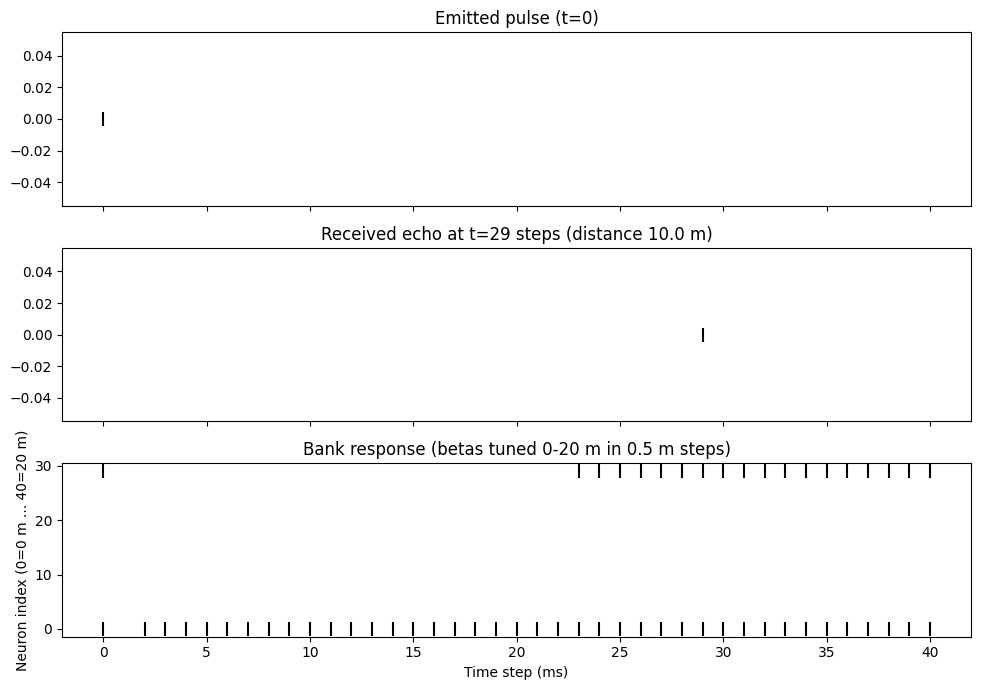

In [ ]:
# Adjustable echo distance (meters)
echo_distance_m = 10.0
echo_step = meters_to_timesteps(echo_distance_m)

# Build spike trains: emitted at t=0, echo at echo_step
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)
max_time_steps = max(int(timesteps.max().item()) + 20, 80)
spike_emitted = torch.zeros(max_time_steps)
spike_emitted[0] = 1.0
spike_received = torch.zeros(max_time_steps)
if echo_step < max_time_steps:
    spike_received[echo_step] = 1.0
spike_in = (spike_emitted + spike_received).clamp(0.0, 1.0)

# Compute per-distance betas using the analytic formula from the previous appendix
base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")
betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
betas[~mask] = 1.0  # immediate echo case

print(betas)

def run_bank(spike_train: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    """Run a bank of LIF neurons (one per beta) over a shared 1D spike train."""
    outputs = []
    for b in betas:
        lif = snn.Leaky(beta=b, threshold=threshold)
        mem = torch.tensor(priming_voltage)
        spk_trace = []
        for t in range(len(spike_train)):
            cur_input = spike_train[t] * weight
            spk, mem = lif(cur_input, mem)
            spk_trace.append(spk)
        outputs.append(torch.stack(spk_trace))
    return torch.stack(outputs)

spk_bank = run_bank(spike_in, betas)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
spikeplot.raster(spike_emitted.unsqueeze(1), ax=axes[0], s=100, c="black", marker="|")
axes[0].set_title("Emitted pulse (t=0)")
spikeplot.raster(spike_received.unsqueeze(1), ax=axes[1], s=100, c="black", marker="|")
axes[1].set_title(f"Received echo at t={echo_step} steps (distance {echo_distance_m} m)")
spikeplot.raster(spk_bank, ax=axes[2], s=100, c="black", marker="|")
axes[2].set_title("Bank response (betas tuned 0-20 m in 0.5 m steps)")
axes[2].set_ylabel("Neuron index (0=0 m ... 40=20 m)")
axes[2].set_xlabel("Time step (ms)")
plt.tight_layout()
plt.show()


In [32]:
# Adjustable echo distance (meters)
echo_distance_m = 10.0
echo_step = meters_to_timesteps(echo_distance_m)

# Build spike trains: emitted at t=0, echo at echo_step
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)
max_time_steps = max(int(timesteps.max().item()) + 20, 80)
spike_emitted = torch.zeros(max_time_steps)
spike_emitted[0] = 1.0
spike_received = torch.zeros(max_time_steps)
if echo_step < max_time_steps:
    spike_received[echo_step] = 1.0
spike_in = (spike_emitted + spike_received).clamp(0.0, 1.0)

# Compute per-distance betas using the analytic formula from the previous appendix
base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")
betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
betas[~mask] = 1.0  # immediate echo case

print(betas)

def run_bank(spike_train: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    """Run a bank of LIF neurons (one per beta) over a shared 1D spike train."""
    spike_outputs = []
    mem_outputs = []
    for b in betas:
        lif = snn.Leaky(beta=float(b), threshold=threshold)
        spk_out, mem_out = run_lif(spike_train)
        spike_outputs.append(torch.stack(spk_out))
        mem_outputs.append(torch.stack(mem_out))
    return torch.stack(spike_outputs), torch.stack(mem_outputs)

spk_bank = run_bank(spike_in, betas)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
spikeplot.raster(spike_emitted.unsqueeze(1), ax=axes[0], s=100, c="black", marker="|")
axes[0].set_title("Emitted pulse (t=0)")
spikeplot.raster(spike_received.unsqueeze(1), ax=axes[1], s=100, c="black", marker="|")
axes[1].set_title(f"Received echo at t={echo_step} steps (distance {echo_distance_m} m)")
spikeplot.raster(spk_bank, ax=axes[2], s=100, c="black", marker="|")
axes[2].set_title("Bank response (betas tuned 0-20 m in 0.5 m steps)")
axes[2].set_ylabel("Neuron index (0=0 m ... 40=20 m)")
axes[2].set_xlabel("Time step (ms)")
plt.tight_layout()
plt.show()


tensor([1.0000, 0.1000, 0.4642, 0.5623, 0.6813, 0.7197, 0.7743, 0.7943, 0.8254,
        0.8377, 0.8577, 0.8660, 0.8733, 0.8859, 0.8913, 0.9006, 0.9047, 0.9120,
        0.9152, 0.9211, 0.9237, 0.9284, 0.9306, 0.9345, 0.9363, 0.9380, 0.9412,
        0.9427, 0.9454, 0.9467, 0.9490, 0.9501, 0.9522, 0.9532, 0.9550, 0.9559,
        0.9567, 0.9583, 0.9590, 0.9604, 0.9611])


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor